In [1]:
import kagglehub

# download dataset
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to downloaded dataset:", data_dir)

# Path to downloaded dataset: /Users/hongong/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1
# Path to downloaded dataset: /home/hongong/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1

/home/hongong/anaconda3/envs/aio2024-homework/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to downloaded dataset: /home/hongong/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import patches
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights, ResNet50_Weights
import tqdm

# Data preparation

In [3]:
class MyDataset(Dataset):

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for objj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                # keep images that have single object
                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # get image size for normalization
        image_width = int(root.find("size/width").text)
        image_height = int(root.find("size/height").text)

        label = None
        bbox = None
        for obj in root.findall("object"):
            name = obj.find("name").text

            # take the first label
            if label is None:
                label = name

                # get bounding box coordinates
                xmin = int(obj.find("bndbox/xmin").text)
                ymin = int(obj.find("bndbox/ymin").text)
                xmax = int(obj.find("bndbox/xmax").text)
                ymax = int(obj.find("bndbox/ymax").text)

                # normalize bounding box coordinates to [0, 1]
                bbox = (
                    xmin / image_width,
                    ymin / image_height,
                    xmax / image_width,
                    ymax / image_height,
                )

        # convert label to numerical representation (0: cat, 1: dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1

        return label_num, torch.tensor(bbox, dtype=torch.float32)

    def __init__(self, annotations_dir, image_dir, transforms=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_files = self.filter_images_with_multiple_objects()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # image path
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)

        idx2 = np.random.randint(0, len(self.image_files) - 1)
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)

        # annotation path
        annotation_name1 = os.path.splitext(img1_file)[0] + ".xml"
        img1_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name1)
        )

        annotation_name2 = os.path.splitext(img2_file)[0] + ".xml"
        img2_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name2)
        )

        # load image
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        # horizontal merge
        merged_image = Image.new(
            "RGB", (img1.width + img2.width, max(img1.height, img2.height))
        )
        merged_image.paste(img1, (0, 0))
        merged_image.paste(img2, (img1.width, 0))
        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)

        merged_annotations = []

        # no change for objects from img1, already normalized
        merged_annotations.append(
            {"bbox": img1_annotations[1].tolist(), "label": img1_annotations[0]}
        )

        # adjust bbox coordinates for objects from img2 AND normalize
        new_bbox = [
            # normalize xmin
            (img2_annotations[1][0] * img2.width + img1.width) / merged_w,
            # normalize ymin
            img2_annotations[1][1] * img2.height / merged_h,
            # normalize xmax
            (img2_annotations[1][2] * img2.width + img1.width) / merged_w,
            # normalize ymax
            img2_annotations[1][3] * img2.height / merged_h,
        ]
        merged_annotations.append({"bbox": new_bbox, "label": img2_annotations[0]})

        # convert merged image to tensor
        if self.transforms:
            merged_image = self.transforms(merged_image)
        else:
            merged_image = transforms.ToTensor()(merged_image)

        # convert annotations to 1D tensor, with shape (4,) for bbox and (1,)  for label
        annotations = torch.zeros((len(merged_annotations), 5))
        for i, ann in enumerate(merged_annotations):
            annotations[i] = torch.cat(
                (torch.tensor(ann["bbox"]), torch.tensor([ann["label"]]))
            )

        return merged_image, annotations

In [4]:
# Data directory
annotations_dir = os.path.join(data_dir, "annotations")
image_dir = os.path.join(data_dir, "images")

# Define transformations
trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Create dataset and dataloaders
dataset = MyDataset(annotations_dir, image_dir, transforms=trans)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Modeling

In [5]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes):
        super(SimpleYOLO, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.num_classes = num_classes

        # Remove the final classification layer of ResNet
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        # Add the YOLO head
        self.fcs = nn.Linear(
            2048, 2 * 2 * (4 + self.num_classes)
        )  # 2 is for the number of grid cell

    def forward(self, x):
        # x shape: (batch_size, C, H, W)
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(
            features, (1, 1)
        )  # shape: (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # shape: (batch_size, 2048)
        features = self.fcs(features)
        return features

In [6]:
# Initialize model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2  # Assuming two classes: dog and cat
class_to_idx = {"dog": 0, "cat": 1}

model = SimpleYOLO(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/hongong/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 17.1MB/s]


# Training

In [7]:
def calculate_loss(output, targets, device, num_classes):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()
    batch_size = output.shape[0]
    total_loss = 0

    output = output.view(
        batch_size, 2, 2, 4 + num_classes
    )  # reshape to (batch_size, grid_y, grid_x, 4 + num_classes)

    for i in range(batch_size):  # iterate through each image in the batch
        for j in range(len(targets[i])):  # iterate through each object in the image
            # determine which grid cell the object's center falls into
            # assuming bbox coordinates are normalized to [0, 1]
            bbox_center_x = (targets[i][j][0] + targets[i][j][2]) / 2
            bbox_center_y = (targets[i][j][1] + targets[i][j][3]) / 2

            grid_x = int(
                bbox_center_x * 2
            )  # multiply by number of grid cells (2 in this case)
            grid_y = int(bbox_center_y * 2)

            # 1. classification loss for the responsible grid cell
            # convert label to one-hot encoding
            label_one_hot = torch.zeros(num_classes, device=device)
            label_one_hot[int(targets[i][j][4])] = 1

            # classification loss (using cross-entropy loss)
            classification_loss = ce_loss(output[i, grid_y, grid_x, 4:], label_one_hot)

            # 2. regression loss for the responsible grid cell
            bbox_target = targets[i][j][:4].to(device)
            regression_loss = mse_loss(output[i, grid_y, grid_x, :4], bbox_target)

            # 3. No object loss for the other grid cell
            no_obj_loss = 0
            for other_grid_y in range(2):
                for other_grid_x in range(2):
                    if other_grid_y != grid_y and other_grid_x != grid_x:
                        no_obj_loss += mse_loss(
                            output[i, other_grid_y, other_grid_x, 4],
                            torch.zeros(4, device=device),
                        )
            total_loss += classification_loss + regression_loss + no_obj_loss

    return total_loss / batch_size  # average loss over the batch

In [8]:
def evaluate_model(model, data_loader, device, num_classes):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, targets in tqdm.tqdm(data_loader, desc="Validation", leave=False):
            images = images.to(device)
            output = model(images)
            total_loss = calculate_loss(output, targets, device, num_classes)
            running_loss += total_loss.item()

            # Reshape output to (batch_size, grid_y, grid_x, 4 + num_classes)
            output = output.view(images.shape[0], 2, 2, 4 + num_classes)

            # Collect predictions and targets for mAP calculation
            for batch_idx in range(images.shape[0]):
                for target in targets[batch_idx]:
                    # Determine responsible grid cell
                    bbox_center_x = (target[0] + target[2]) / 2
                    bbox_center_y = (target[1] + target[3]) / 2
                    grid_x = int(bbox_center_x * 2)
                    grid_y = int(bbox_center_y * 2)

                    # Class prediction (index of max probability)
                    prediction = output[batch_idx, grid_y, grid_x, 4:].argmax().item()
                    all_predictions.append(prediction)
                    all_targets.append(target[4].item())

    val_loss = running_loss / len(data_loader)

    # Convert lists to tensors for PyTorch's metric functions
    all_predictions = torch.tensor(all_predictions, device=device)
    all_targets = torch.tensor(all_targets, device=device)

    # Calculate accuracy
    val_accuracy = (all_predictions == all_targets).float().mean()
    return val_loss, val_accuracy.item()

In [9]:
def train_model(
    model, train_loader, val_loader, optimizer, num_epochs, device, num_classes
):
    best_val_accuracy = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in tqdm.tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        running_loss = 0.0
        for images, targets in tqdm.tqdm(train_loader, desc="Batches", leave=False):
            images = images.to(device)
            optimizer.zero_grad()
            output = model(images)
            total_loss = calculate_loss(output, targets, device, num_classes)
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        val_loss, val_accuracy = evaluate_model(model, val_loader, device, num_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [10]:
def inference(model, image_path, transform, device, class_to_idx, threshold=0.5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    original_witdh, original_height = image.size

    # resize the image to match the input size of the model (e.g. 448x448)
    resized_image = image.resize((448, 448))
    resized_witdh, resized_height = resized_image.size

    # apply the same transformations as we did for the training data
    transformed_image = transform(resized_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        output = output.view(1, 2, 2, 4 + len(class_to_idx))  # reshape to 2x2 grid

        fig, ax = plt.subplots(1)
        ax.axis("off")
        ax.imshow(resized_image)  # display resized image

        for grid_y in range(2):
            for grid_x in range(2):
                # get the class prediction and bbox for the current grid
                class_pred = output[0, grid_y, grid_x, 4:].argmax().item()
                bbox = output[0, grid_y, grid_x, :4].tolist()  # predicted bbox

                # confidence (probability) of the class prediction
                confidence = torch.softmax(output[0, grid_y, grid_x, 4:], dim=0)[
                    class_pred
                ].item()

                # scale the bbox back to the resized image size
                # assuming bbox normalized to [0, 1]
                x_min = bbox[0] * (resized_witdh / 2) + grid_x * (resized_witdh / 2)
                y_min = bbox[1] * (resized_height / 2) + grid_y * (resized_height / 2)
                x_max = bbox[2] * (resized_witdh / 2) + grid_x * (resized_witdh / 2)
                y_max = bbox[3] * (resized_height / 2) + grid_y * (resized_height / 2)

                # draw the bbox and label on the image if confidence is above the threshold
                if confidence > threshold:
                    rect = patches.Rectangle(
                        (x_min, y_min),
                        x_max - x_min,
                        y_max - y_min,
                        linewidth=1,
                        edgecolor="r",
                        facecolor="none",
                    )
                    ax.add_patch(rect)
                    plt.text(
                        x_min,
                        y_min,
                        f"{list(class_to_idx.keys())[class_pred]}: {confidence:.2f}",
                        color="white",
                        fontsize=12,
                        bbox=dict(facecolor="red", alpha=0.5),
                    )

        plt.show()

In [11]:
%%time
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=5,
    device=device,
    num_classes=num_classes,
)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]/home/hongong/anaconda3/envs/aio2024-homework/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epochs:  20%|██        | 1/5 [00:27<01:49, 27.41s/it]

Epoch 1/5, Train Loss: 1.1132, Val Loss: 0.9677, Val Accuracy: 0.8060


Epochs:  40%|████      | 2/5 [00:54<01:21, 27.26s/it]

Epoch 2/5, Train Loss: 0.8870, Val Loss: 0.8161, Val Accuracy: 0.8223


Epochs:  60%|██████    | 3/5 [01:21<00:54, 27.19s/it]

Epoch 3/5, Train Loss: 0.7927, Val Loss: 0.8041, Val Accuracy: 0.8182


Epochs:  80%|████████  | 4/5 [01:49<00:27, 27.29s/it]

Epoch 4/5, Train Loss: 0.6955, Val Loss: 0.6934, Val Accuracy: 0.8501


Epochs: 100%|██████████| 5/5 [02:16<00:00, 27.30s/it]

Epoch 5/5, Train Loss: 0.6268, Val Loss: 1.2023, Val Accuracy: 0.7809
CPU times: user 5min 14s, sys: 682 ms, total: 5min 15s
Wall time: 2min 16s


/tmp/ipykernel_3579/1002794648.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


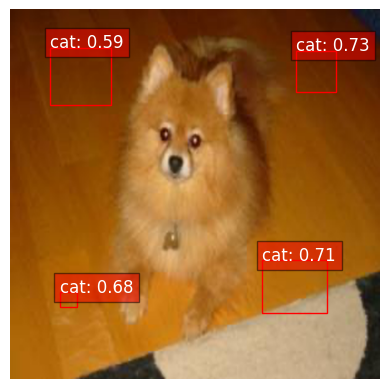

In [15]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
# Inference on a sample image
image_path = os.path.join(image_dir, "Cats_Test12.png")
inference(model, image_path, trans, device, class_to_idx, threshold=0.5)